#### Notes from the Readme File

A: The usage of the data set is unrestricted. But you should provide the link to our original download site, acknowledge the NIH Clinical Center and provide a citation to our CVPR 2017 paper

A: ‘No finding’ means the 14 listed disease patterns are not found in the image. 

https://www.kaggle.com/nih-chest-xrays/data

Citations
Wang X, Peng Y, Lu L, Lu Z, Bagheri M, Summers RM. ChestX-ray8: Hospital-scale Chest X-ray Database and Benchmarks on Weakly-Supervised Classification and Localization of Common Thorax Diseases. IEEE CVPR 2017, ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf

NIH News release: NIH Clinical Center provides one of the largest publicly available chest x-ray datasets to scientific community

Original source files and documents: https://nihcc.app.box.com/v/ChestXray-NIHCC/folder/36938765345

### Context Behind Dataset for Final Writeup:

Dataset was gathered by the NIH and contains over 100,000 anonymized chest x-ray images from more than 30,000 patients.  

# Goal
The goal is to use a simple model to classify x-ray images in Keras, the notebook how to use the ```flow_from_dataframe``` to deal with messier datasets

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
folderlist = glob(os.path.join('/data', 'images*'))
imglist = []
for folder in folderlist:
    tmp = glob(os.path.join(folder, "images", "*.png"))
    imglist += tmp
all_image_paths = {os.path.basename(x): x for x in imglist}
# all_image_paths = {os.path.basename(x): x for x in 
#                    glob(os.path.join('.', 'data', 'images*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
num_selected = 10000
tmp = {key: all_image_paths[key] for key in sorted(list(all_image_paths.keys()))[num_selected:]}
all_xray_df['path'] = all_xray_df['Image Index'][num_selected:].map(tmp.get)
all_xray_df = all_xray_df[num_selected:]
# all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
# all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)


#all_xray_df['Patient Age'] = all_xray_df['Patient Age'].map(lambda x: int(x[:-1]))
all_xray_df.sample(3)


Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
105035,00028186_000.png,No Finding,0,28186,51,M,PA,2992,2991,0.143,0.143,NaN,/data/images_012/images/00028186_000.png
51753,00013071_004.png,No Finding,4,13071,10,F,PA,2570,2773,0.143,0.143,NaN,/data/images_006/images/00013071_004.png
71810,00017698_005.png,No Finding,5,17698,73,M,PA,2754,2991,0.143,0.143,NaN,/data/images_008/images/00017698_005.png


In [3]:
all_xray_df.shape

(102120, 13)

# Preprocessing Labels
Here we take the labels and make them into a more clear format. The primary step is to see the distribution of findings and then to convert them to simple binary labels

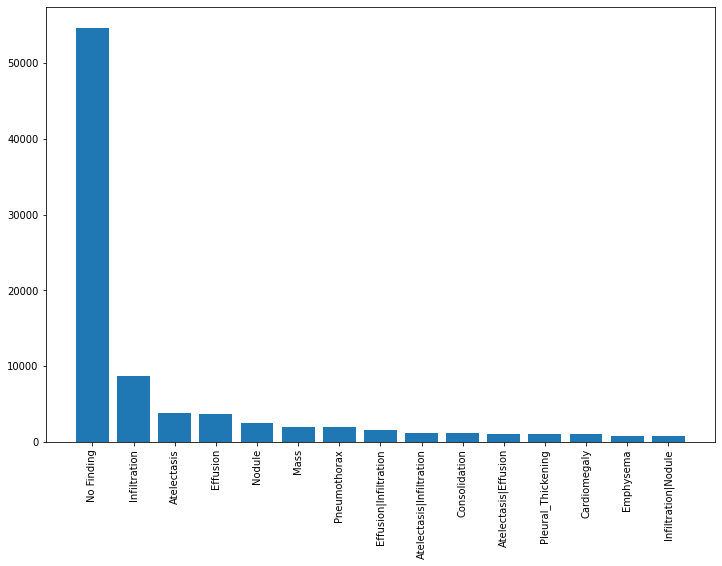

In [4]:
label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

In [5]:
all_xray_df['Finding Labels'] = all_xray_df['Finding Labels'].map(lambda x: x.replace('No Finding', ''))
from itertools import chain
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if c_label in finding else 0)
all_xray_df.sample(3)

All Labels (14): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Effusion,Emphysema,Fibrosis,Hernia,Infiltration,Mass,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
75550,00018541_006.png,,6,18541,53,F,AP,2500,2048,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14482,00003762_000.png,,0,3762,47,M,PA,2500,2048,0.171,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
69786,00017205_000.png,,0,17205,61,F,PA,2048,2500,0.168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
all_labels

['Atelectasis',
 'Cardiomegaly',
 'Consolidation',
 'Edema',
 'Effusion',
 'Emphysema',
 'Fibrosis',
 'Hernia',
 'Infiltration',
 'Mass',
 'Nodule',
 'Pleural_Thickening',
 'Pneumonia',
 'Pneumothorax']

### Clean categories
Since we have too many categories, we can prune a few out by taking the ones with only a few examples

In [7]:
# keep at least 1000 cases
MIN_CASES = 1000
all_labels = [c_label for c_label in all_labels if all_xray_df[c_label].sum()>MIN_CASES]
print('Clean Labels ({})'.format(len(all_labels)), 
      [(c_label,int(all_xray_df[c_label].sum())) for c_label in all_labels])

Clean Labels (13) [('Atelectasis', 10670), ('Cardiomegaly', 2476), ('Consolidation', 4271), ('Edema', 2150), ('Effusion', 12410), ('Emphysema', 2295), ('Fibrosis', 1407), ('Infiltration', 18291), ('Mass', 5454), ('Nodule', 5887), ('Pleural_Thickening', 3060), ('Pneumonia', 1296), ('Pneumothorax', 4862)]


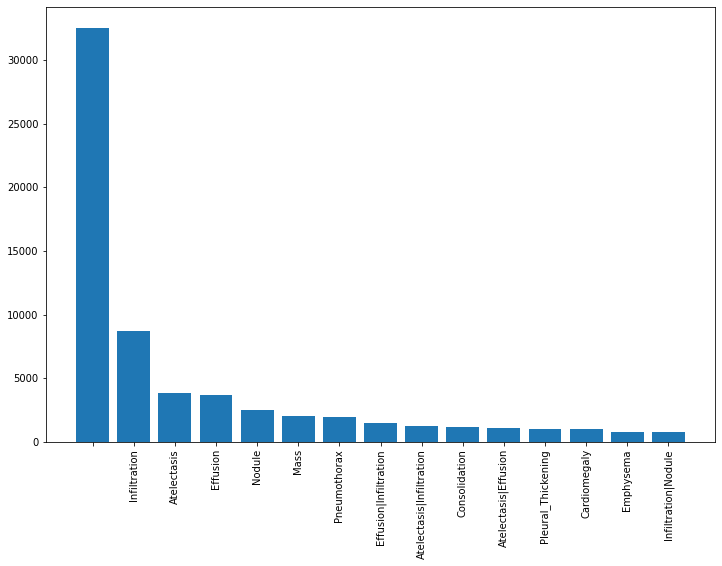

In [8]:
# since the dataset is very unbiased, we can resample it to be a more reasonable collection
# weight is 0.1 + number of findings
sample_weights = all_xray_df['Finding Labels'].map(lambda x: len(x.split('|')) if len(x)>0 else 0).values + 4e-2
sample_weights /= sample_weights.sum()
all_xray_df = all_xray_df.sample(80000, weights=sample_weights)

label_counts = all_xray_df['Finding Labels'].value_counts()[:15]
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
_ = ax1.set_xticklabels(label_counts.index, rotation = 90)

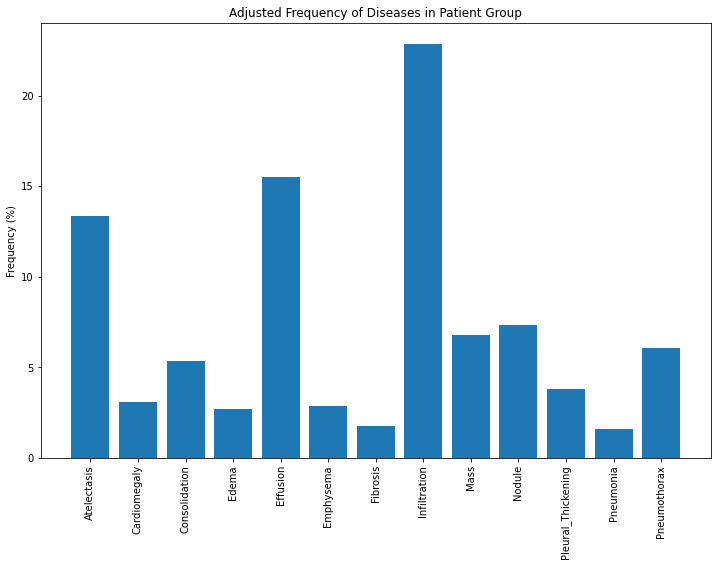

In [9]:
label_counts = 100*np.mean(all_xray_df[all_labels].values,0)
fig, ax1 = plt.subplots(1,1,figsize = (12, 8))
ax1.bar(np.arange(len(label_counts))+0.5, label_counts)
ax1.set_xticks(np.arange(len(label_counts))+0.5)
ax1.set_xticklabels(all_labels, rotation = 90)
ax1.set_title('Adjusted Frequency of Diseases in Patient Group')
_ = ax1.set_ylabel('Frequency (%)')

# Prepare Training Data
Here we split the data into training and validation sets and create a single vector (disease_vec) with the 0/1 outputs for the disease status (what the model will try and predict)

In [10]:
all_xray_df['disease_vec'] = all_xray_df.apply(lambda x: [x[all_labels].values], 1).map(lambda x: x[0])

In [11]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(all_xray_df, 
                                   test_size = 0.8, 
                                   random_state = 2018,
                                   stratify = all_xray_df['Finding Labels'].map(lambda x: x[:4]))
print('train', train_df.shape[0], 'validation', valid_df.shape[0])

train 16000 validation 64000


In [12]:
5000/0.8

6250.0

# Create Data Generators
Here we make the data generators for loading and randomly transforming images

In [13]:
valid_df['newLabel'] = valid_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)
# train_df['newLabel'] = train_df.apply(lambda x: x['Finding Labels'].split('|'), axis=1)

/home/xunxia/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [14]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (224,224)
core_idg = ImageDataGenerator(samplewise_center=True, 
                              samplewise_std_normalization=True, 
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.05, 
                              width_shift_range=0.1, 
                              rotation_range=5, 
                              shear_range = 0.1,
                              fill_mode = 'reflect',
                              zoom_range=0.15)

Using TensorFlow backend.
/home/xunxia/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/xunxia/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/xunxia/anaconda3/envs/tf_cpu/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/xunxia/anacond

In [15]:
# train_gen = core_idg.flow_from_dataframe(dataframe=train_df, 
#                              directory=None,
#                              x_col = 'path',
#                             y_col = 'newLabel', 
#                              class_mode = 'categorical',
#                             classes = all_labels,
#                             target_size = IMG_SIZE,
#                              color_mode = 'grayscale',
#                             batch_size = 32)

valid_gen = core_idg.flow_from_dataframe(dataframe=valid_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = "rgb",
                            batch_size = 256) # we can use much larger batches for evaluation

test_X, test_Y = next(core_idg.flow_from_dataframe(dataframe=valid_df, 
                             directory=None,
                             x_col = 'path',
                            y_col = 'newLabel', 
                             class_mode = 'categorical',
                            classes = all_labels,
                            target_size = IMG_SIZE,
                             color_mode = "rgb",
                            batch_size = 5000))

Found 37902 validated image filenames belonging to 13 classes.
Found 37902 validated image filenames belonging to 13 classes.


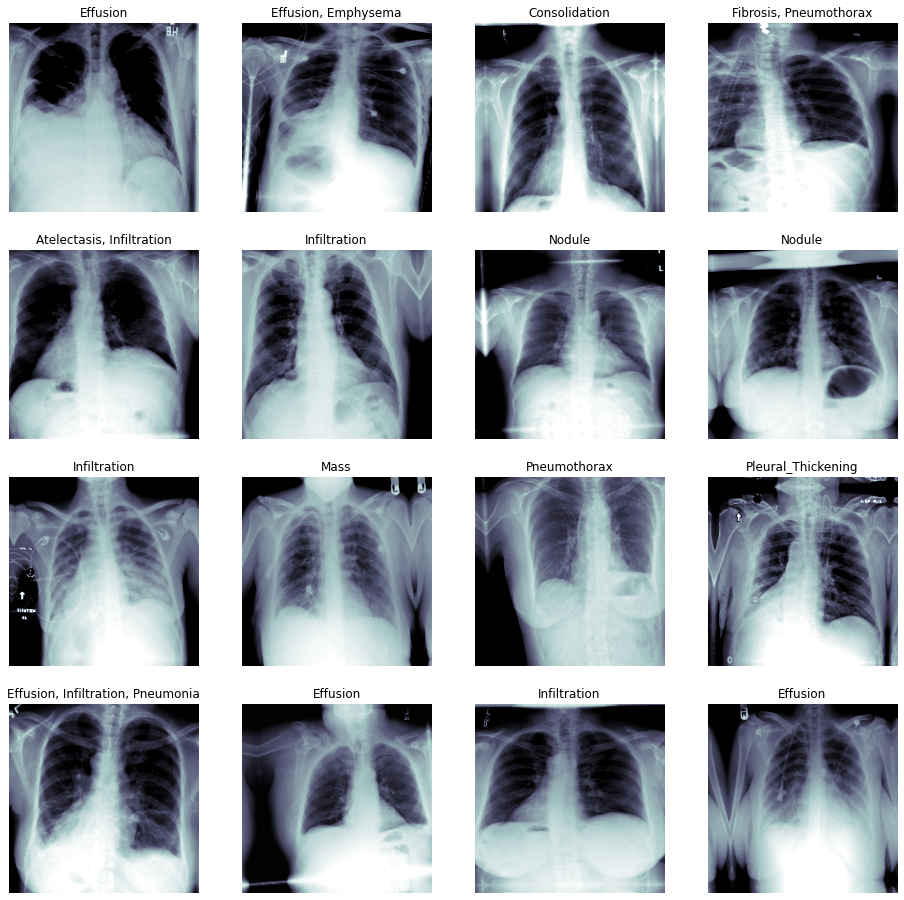

In [16]:
t_x, t_y = next(valid_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone', vmin = -1.5, vmax = 1.5)
    c_ax.set_title(', '.join([n_class for n_class, n_score in zip(all_labels, c_y) 
                             if n_score>0.5]))
    c_ax.axis('off')

# Create a simple model
Here we make a simple model to train using MobileNet as a base and then adding a GAP layer (Flatten could also be added), dropout, and a fully-connected layer to calculate specific features

In [17]:
test_X.shape

(5000, 224, 224, 3)

In [18]:
from keras.applications.vgg19 import VGG19
from keras.applications.vgg19 import preprocess_input as VGG19_preprocess_input
# from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
from keras import optimizers, callbacks, regularizers
base_vgg19_model = VGG19(input_shape =  (224,224,3), 
                                 include_top = False, weights ="imagenet")
multi_disease_model = Sequential()
multi_disease_model.add(base_vgg19_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'sigmoid'))
multi_disease_model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
                           metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)      

In [19]:
# from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
# weight_path="{}_weights.best.hdf5".format('xray_class')

# checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
#                              save_best_only=True, mode='min', save_weights_only = True)

# early = EarlyStopping(monitor="val_loss", 
#                       mode="min", 
#                       patience=5)
# callbacks_list = [checkpoint, early]

# First Round
Here we do a first round of training to get a few initial low hanging fruit results

In [20]:
# multi_disease_model.fit_generator(train_gen, 
#                                   steps_per_epoch=100,
#                                   validation_data = (test_X, test_Y), 
#                                   epochs = 1, 
#                                   callbacks = callbacks_list)

# Check Output
Here we see how many positive examples we have of each category

In [21]:
for c_label, s_count in zip(all_labels, 100*np.mean(test_Y,0)):
    print('%s: %2.2f%%' % (c_label, s_count))

Atelectasis: 23.28%
Cardiomegaly: 4.88%
Consolidation: 9.16%
Edema: 4.24%
Effusion: 26.26%
Emphysema: 5.44%
Fibrosis: 2.90%
Infiltration: 39.02%
Mass: 11.48%
Nodule: 12.44%
Pleural_Thickening: 6.46%
Pneumonia: 2.84%
Pneumothorax: 9.88%


In [53]:
# pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

# ROC Curves
While a very oversimplified metric, we can show the ROC curve for each metric

In [54]:
# from sklearn.metrics import roc_curve, auc
# fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
# for (idx, c_label) in enumerate(all_labels):
#     fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
#     c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
# c_ax.legend()
# c_ax.set_xlabel('False Positive Rate')
# c_ax.set_ylabel('True Positive Rate')
# fig.savefig('barely_trained_net.png')

### Optimizer Selection

In [55]:
# optimizers_list = [('sgd',optimizers.SGD( lr=.1) ),
#                    ('sgd_momentum',optimizers.SGD(lr=.1, momentum=.9) ),
#                    ('adagrad',optimizers.Adagrad()),
#                    ('adadelta',optimizers.Adadelta()),
#                    ('adam', optimizers.Adam()) 
#                   ]

# early = EarlyStopping(monitor="val_loss", 
#                       mode="min", 
#                       patience=5)
# callbacks_list = [early]

In [56]:
# plt.figure(figsize=(20,5))
# for optimizer in optimizers_list:
#     multi_disease_model.compile(optimizer = optimizer[1], loss = 'binary_crossentropy',
#                            metrics = ['binary_accuracy', 'mae'])
    
#     history = multi_disease_model.fit_generator(train_gen, 
#                                   steps_per_epoch=1000,
#                                   validation_data = (test_X, test_Y), 
#                                   epochs = 50, 
#                                   callbacks = callbacks_list)
      
    
#     plt.plot(history.history['val_loss'])
    
# plt.legend([x[0] for x in optimizers_list], loc='upper right')
# plt.title('model accuracy')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.show()
# plt.savefig('optimizer_selection.png', bbox_inches='tight')

# Continued Training
Now we do a much longer training process to see how the results improve

In [57]:
# multi_disease_model.fit_generator(train_gen, 
#                                   steps_per_epoch = 100,
#                                   validation_data =  (test_X, test_Y), 
#                                   epochs = 100, 
#                                   callbacks = callbacks_list)

In [58]:
# import tensorflow as tf
# latest = tf.train.latest_checkpoint('/home/xunxia/results/latest_simple_vgg19/weights.best.hdf5')


In [59]:
# result = multi_disease_model.evaluate(test_X, test_Y, verbose=1)


1024/1024 [==============================] - 196s 191ms/step


In [60]:
# result

[0.6827171444892883, 0.5377854723483324, 0.47359039448201656]

In [61]:
# multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_6 ( (None, 512)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 13)                6669      
Total params: 20,293,709
Trainable params: 20,293,709
Non-trainable params: 0
________________________________________________________________

In [22]:
# load the best weights
multi_disease_model.load_weights('/home/xunxia/results/latest_simple_vgg19/weights.best.hdf5')

In [23]:
result = multi_disease_model.evaluate(test_X, test_Y, verbose=1)

5000/5000 [==============================] - 954s 191ms/step


In [24]:
result

[0.36762132482528687, 0.8775538450241089, 0.16905301237106324]

In [25]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

5000/5000 [==============================] - 953s 191ms/step


In [29]:
pred_Y.shape, test_X.shape

((5000, 13), (5000, 224, 224, 3))

In [28]:
for i in range(test_Y.shape[1]):
    positive_pred = np.histogram(pred_Y[test_Y[:,i]==1,i])
    centers = np.array([positive_pred[1][t]/2+positive_pred[1][t-1]/2 for t in range(1, len(positive_pred[1]))])
    plt.plot(centers, positive_pred[0], label="posi")
    negative_pred = np.histogram(pred_Y[test_Y[:,i]==0,i])
    centers = np.array([negative_pred[1][t]/2+negative_pred[1][t-1]/2 for t in range(1, len(negative_pred[1]))])
    plt.plot(centers, negative_pred[0], label="nega")
    plt.legend()
    plt.savefig("/home/xunxia/Documents/cpu/cpu2/NIH-Chest-X-rays-Classification/result_imgs/{}.png".format(i))
    plt.close()
#     break
#     plt.show()

In [101]:
positive_pred

(array([15, 38, 38, 67, 54, 38, 26, 14,  2,  5]),
 array([0.03898889, 0.05419286, 0.06939683, 0.0846008 , 0.09980477,
        0.11500874, 0.13021271, 0.14541668, 0.16062066, 0.17582463,
        0.1910286 ], dtype=float32))

In [34]:
import csv
with open('output.csv', mode='w') as output_file:
    output_writer = csv.writer(output_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    output_writer.writerow(["loss=%.4f, accuracy=%.4f, mean_absolute_error=%.4f"%(result[0], result[1], result[2])])
    for i in range(test_Y.shape[0]):
        output_writer.writerow(["%d(%.2f)"%(test_Y[i,j], pred_Y[i,j]) for j in range(test_Y.shape[1])])
#         output_writer.writerow(["gt=%d, pred=%.2f"%(test_Y[i,j], pred_Y[i,j]) for j in range(test_Y.shape[1])])
#     output_writer.writerow(['Erica Meyers', 'IT', 'March'])

In [93]:
for 
test_Y[0], pred_Y[0]

(array([0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1.], dtype=float32),
 array([0.07933071, 0.00084093, 0.06968248, 0.00521535, 0.09821981,
        0.04227832, 0.05085614, 0.16735613, 0.01406321, 0.00603393,
        0.04211375, 0.02011162, 0.34713775], dtype=float32))

In [89]:
from sklearn.metrics import multilabel_confusion_matrix
threhold = 0.1
b_pred_Y = pred_Y.copy()
b_pred_Y[b_pred_Y>threhold] = 1
b_pred_Y[b_pred_Y<= threhold] = 0
outpt = multilabel_confusion_matrix(test_Y, b_pred_Y)

In [90]:
outpt.shape

(13, 2, 2)

In [91]:
outpt

array([[[443, 284],
        [159, 138]],

       [[960,   0],
        [ 64,   0]],

       [[440, 459],
        [ 55,  70]],

       [[963,   0],
        [ 61,   0]],

       [[300, 361],
        [114, 249]],

       [[911,  49],
        [ 61,   3]],

       [[840, 147],
        [ 23,  14]],

       [[  4, 569],
        [  2, 449]],

       [[848,   0],
        [176,   0]],

       [[854,   0],
        [170,   0]],

       [[928,   2],
        [ 94,   0]],

       [[991,   0],
        [ 33,   0]],

       [[  0, 889],
        [  0, 135]]])

In [80]:
# look at how often the algorithm predicts certain diagnoses 
for c_label, p_count, t_count in zip(all_labels, 
                                     100*np.mean(pred_Y,0), 
                                     100*np.mean(test_Y,0)):
    print('%s: Dx: %2.2f%%, PDx: %2.2f%%' % (c_label, t_count, p_count))

Atelectasis: Dx: 29.00%, PDx: 9.46%
Cardiomegaly: Dx: 6.25%, PDx: 0.23%
Consolidation: Dx: 12.21%, PDx: 10.80%
Edema: Dx: 5.96%, PDx: 1.36%
Effusion: Dx: 35.45%, PDx: 14.44%
Emphysema: Dx: 6.25%, PDx: 5.58%
Fibrosis: Dx: 3.61%, PDx: 7.45%
Infiltration: Dx: 44.04%, PDx: 22.70%
Mass: Dx: 17.19%, PDx: 1.70%
Nodule: Dx: 16.60%, PDx: 0.94%
Pleural_Thickening: Dx: 9.18%, PDx: 3.89%
Pneumonia: Dx: 3.22%, PDx: 2.46%
Pneumothorax: Dx: 13.18%, PDx: 39.56%


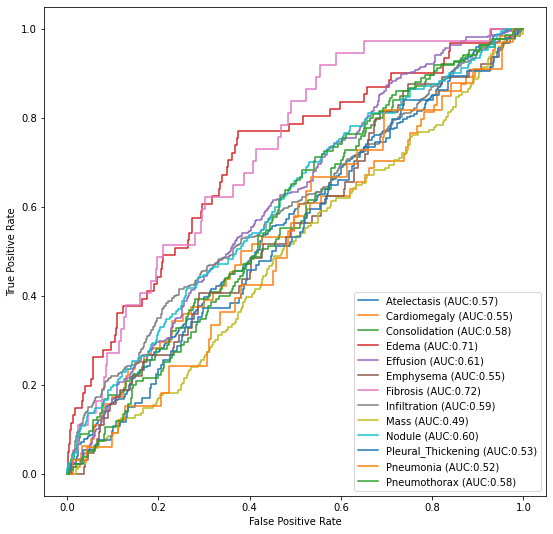

In [81]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('trained_net.png')

# Show a few images and associated predictions

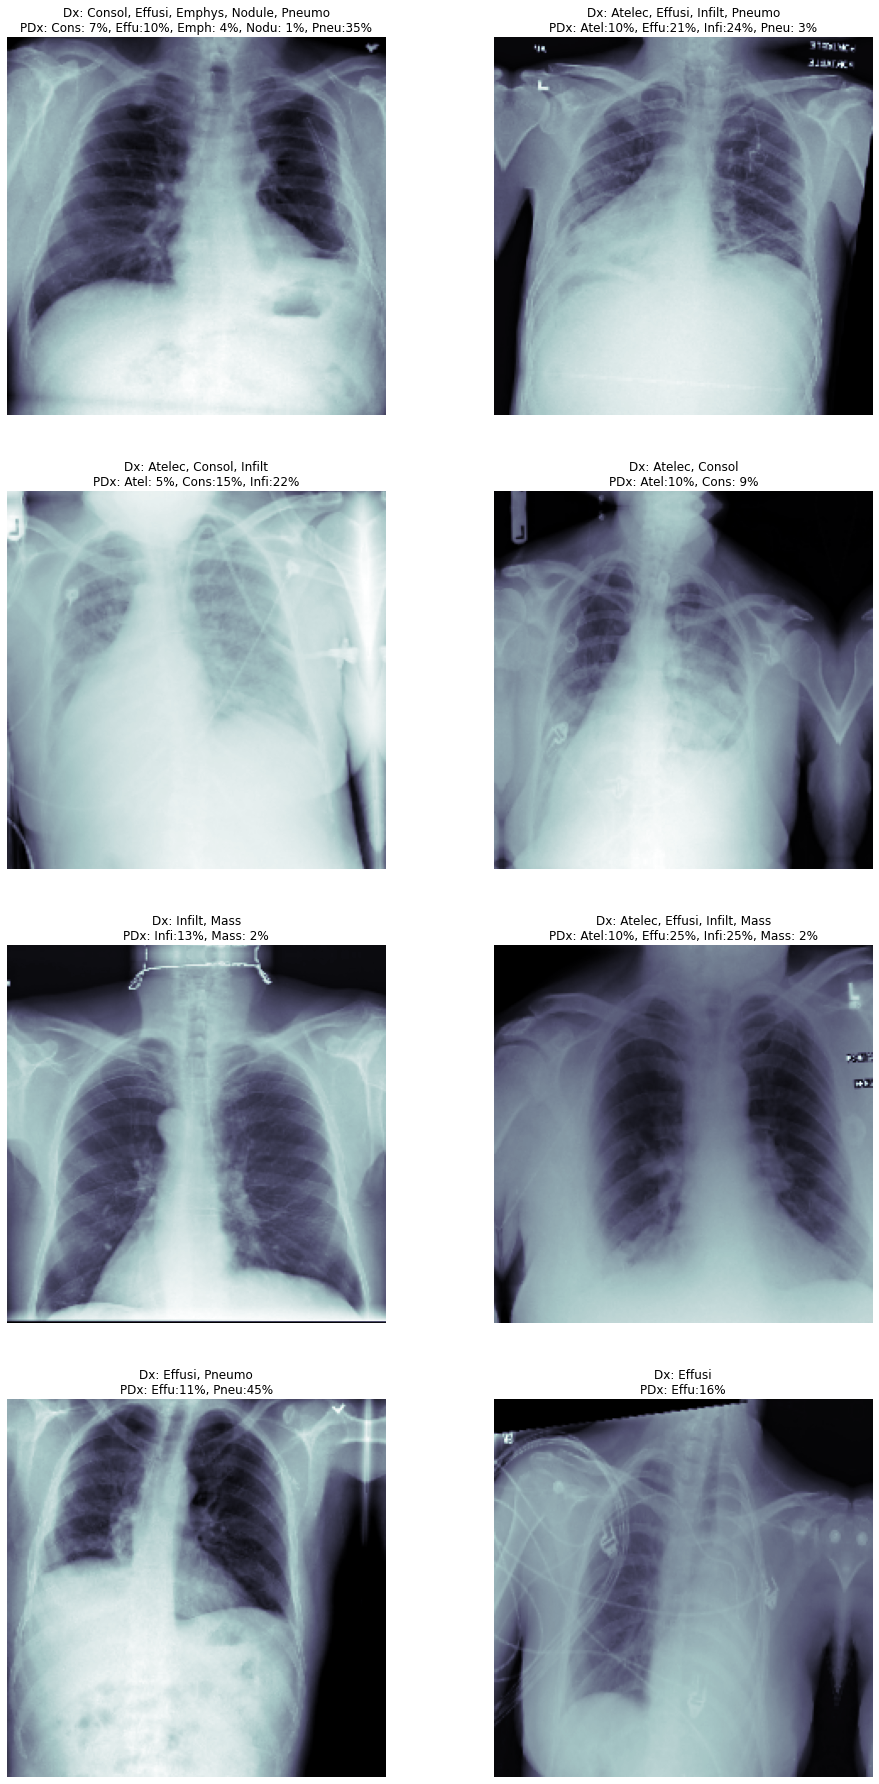

In [82]:
sickest_idx = np.argsort(np.sum(test_Y, 1)<1)
fig, m_axs = plt.subplots(4, 2, figsize = (16, 32))
for (idx, c_ax) in zip(sickest_idx, m_axs.flatten()):
    c_ax.imshow(test_X[idx, :,:,0], cmap = 'bone')
    stat_str = [n_class[:6] for n_class, n_score in zip(all_labels, 
                                                                  test_Y[idx]) 
                             if n_score>0.5]
    pred_str = ['%s:%2.0f%%' % (n_class[:4], p_score*100)  for n_class, n_score, p_score in zip(all_labels, 
                                                                  test_Y[idx], pred_Y[idx]) 
                             if (n_score>0.5) or (p_score>0.5)]
    c_ax.set_title('Dx: '+', '.join(stat_str)+'\nPDx: '+', '.join(pred_str))
    c_ax.axis('off')
fig.savefig('trained_img_predictions.png')